# Load Data

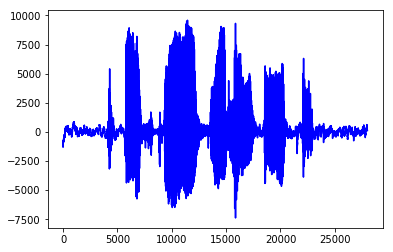

In [1]:
import numpy
import sounddevice as sd
import scipy.io.wavfile as wf
from scipy.fftpack import dct
import matplotlib.pyplot as plt
%matplotlib inline

sample_rate, signal = wf.read('sounds/OSR_us_000_0010_8k.wav') # 8kHz
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds
plt.plot(signal, c='b')
sd.play(signal)

# Pre-Emphasis

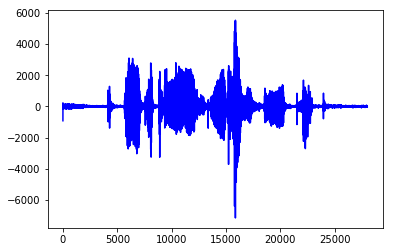

In [2]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1]) #Perfect
plt.plot(emphasized_signal, c='b')
sd.play(emphasized_signal)

# Framing

In [3]:
# Split the signal into short-time frames
frame_size = 0.025
frame_stride = 0.01

# Convert from seconds to samples
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
# Make sure that we have at least 1 frame
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z)

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, 
                num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

In [4]:
frames.shape

(348, 200)

# Window

In [5]:
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation

In [6]:
frames.shape

(348, 200)

# Fourier-Transform and Power Spectrum

In [7]:
NFFT = 512 # or 256
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

# Filter Banks

In [8]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

# Mel-frequency Cepstral Coefficients (MFCCs)

In [9]:
num_ceps = 12
cep_lifter = 22 #refers to the dimensionality of the MFCC vector in the original formulation.

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

# Mean Normalization

In [10]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)